# Forecasting Time Series Patents Applications

Importing necessary pakages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from dataclasses import dataclass

In [ ]:
#Excel
path = '../data/processed/cleaned_data.xlsx'

df = pd.read_excel(path, sheet_name="cleaned_data")

df.tail()

In [3]:
path = '../data/raw/g_patent.tsv'

df = pd.read_csv(path, sep='\t')

df.tail()

C:\Users\HP\AppData\Local\Temp\ipykernel_15488\2130906828.py:3: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')


,patent_id,patent_type,patent_date,patent_title,patent_abstract,wipo_kind,num_claims,withdrawn,filename
8701564,T998013,defensive publication,1980-09-02,Protection of insect pheromones from degradati...,NaN,I4,1,0,pftaps19800902_wk36.zip
8701565,T998014,defensive publication,1980-09-02,"Thiazolyl couplers, coupler compositions and p...",NaN,I4,3,0,pftaps19800902_wk36.zip
8701566,T999001,defensive publication,1980-10-07,Sack handling device,NaN,I4,1,0,pftaps19801007_wk41.zip
8701567,T999002,defensive publication,1980-10-07,Application of polymeric powders to a substrate,NaN,I4,7,0,pftaps19801007_wk41.zip
8701568,T999003,defensive publication,1980-10-07,"Shifted photographic dyes and compositions, el...",NaN,I4,3,0,pftaps19801007_wk41.zip


In [4]:
df.dtypes

patent_id          object
patent_type        object
patent_date        object
patent_title       object
patent_abstract    object
wipo_kind          object
num_claims          int64
withdrawn           int64
filename           object
dtype: object

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Applications")
    plt.grid(True)

In [6]:
def calculate_application_per_month(data: pd.DataFrame, date_column: str):
    """
    Calculate the cumulative count of patent applications per month.

    Parameters:
    - data: DataFrame containing the patent application data

    Returns:
    - DataFrame with the cumulative count of patent applications per month
    """
    # Convert 'FILING_DATE' column to datetime format
    data[date_column] = pd.to_datetime(data[date_column])

    # Extract year and month from 'FILING_DATE'
    data['Time'] = data[date_column].dt.to_period('M')

    # Group by year and month, and count the number of applications in each group
    applications_per_month = data.groupby('Time').size().reset_index(name='Applications')
    # applications_per_month['Cumulative_Count'] = applications_per_month['Applications_Per_Month'].cumsum()
    
    return applications_per_month

In [7]:
series = calculate_application_per_month(data=df, date_column='patent_date')

series

,Time,Applications
0,1976-01,5352
1,1976-02,5231
2,1976-03,7123
3,1976-04,6032
4,1976-05,5969
...,...,...
571,2023-08,35970
572,2023-09,29219
573,2023-10,38048
574,2023-11,29296


In [8]:
def parse_data_from_dataframe(df):
    times = []
    applications = []

    for i, row in df.iterrows():
        times.append(i)
        applications.append(float(row['Applications']))

    return times, applications

In [9]:
@dataclass
class G:
    TEMPERATURES_CSV = '../data/processed/cleaned_data.xlsx'
    times, applications = parse_data_from_dataframe(series)
    TIME = np.array(times)
    SERIES = np.array(applications)
    SPLIT_TIME = 470 # customizeable
    WINDOW_SIZE = 32
    BATCH_SIZE = 16
    SHUFFLE_BUFFER_SIZE = 100

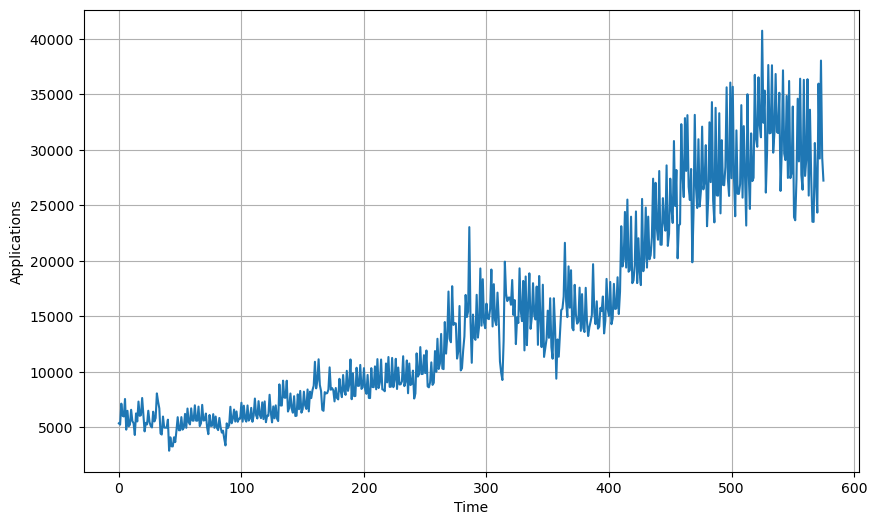

In [12]:
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [13]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining Model Architecture

In [ ]:
def create_model():
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=16, kernel_size=3, strides=1, activation='relu', padding='causal', input_shape = [G.WINDOW_SIZE,1]),
        tf.keras.layers.LSTM(16, return_sequences=True),
        tf.keras.layers.LSTM(16),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    return model

## Adjusting Learning Rate

In [ ]:
def adjust_learning_rate(dataset):
    
    model = create_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch /20))
    
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [ ]:
lr_history = adjust_learning_rate(train_set)